In [1]:
import numpy as np
import pandas as pd
#from numpy.linalg import norm
from sklearn.linear_model import LogisticRegression
#import statsmodels
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [6]:
#RL_info = pd.read_csv('../data/Jan_CSV/RL_info.csv')
#RL_info[['first_scanned_on', 'last_scanned_on']] = RL_info[['first_scanned_on', 'last_scanned_on']].astype(int)
#RL_info['first_scanned_on'] = pd.to_datetime(RL_info['first_scanned_on'], unit='d')
#RL_info['last_scanned_on'] = pd.to_datetime(RL_info['last_scanned_on'], unit='d')
max(RL_info['last_scanned_on'])

Timestamp('2016-02-12 00:50:00')

In [4]:
# Get unique SHAs

RL_info = pd.read_csv('../data/Jan_CSV/RL_info.csv')
RL_info.drop_duplicates(subset=['sha256'], keep='last', inplace=True)
lookup_shas = pd.Series(RL_info['sha256'].values,index=RL_info['index']).to_dict()

RL_info[['first_scanned_on', 'last_scanned_on']] = RL_info[['first_scanned_on', 'last_scanned_on']].astype(int)
RL_info['first_scanned_on'] = pd.to_datetime(RL_info['first_scanned_on'], unit='s')
RL_info['last_scanned_on'] = pd.to_datetime(RL_info['last_scanned_on'], unit='s')
RL_info['scan_length'] = (RL_info['last_scanned_on'] - RL_info['first_scanned_on'])  / np.timedelta64(1, 'D')
id_df = RL_info[['index','sha256','scan_length']]
filter1 = RL_info['index'].values
print(len(filter1))

# Delete the table after use
%reset_selective -f RL_info

3829275


In [5]:
# Get executable files

RL_magic = pd.read_csv('../data/Jan_CSV/RL_magic.csv')
filter2 = RL_magic[RL_magic['sample_type'].str.contains('exec')]['index'].values
print(len(filter2))

# Delete the table after use
%reset_selective -f RL_magic

2426854


In [6]:
# Build the filter and get the SHAs for lookup too

filt = np.intersect1d(filter1, filter2, assume_unique=True)
print("Filter size: ", len(filt))

id_df = id_df[id_df['index'].isin(filt)]


print("ID DF size: ", len(id_df))

sha_list = []
for ind in filt:
    sha_list.append(lookup_shas[ind])
#print(sha_list[0:5])

Filter size:  2242949
ID DF size:  2242949


In [7]:
TG_subs = pd.read_csv('../data/Jan_CSV/TG_submissions_all.csv')
print(len(TG_subs))


TG_subs.drop(['submitted_at','sample','vm'], axis=1, inplace=True)

TG_subs.drop_duplicates(subset=['sha256'], keep='last', inplace=True)
print(len(TG_subs))

TG_subs = TG_subs[TG_subs['sha256'].isin(sha_list)]
print(len(TG_subs))

TG_data = TG_subs['submission_id'].values

id_df = pd.merge(left=id_df, right=TG_subs, how='left', left_on='sha256', right_on='sha256')

4046255
3814330
2119682


In [8]:
print(len(id_df['submission_id']))
print(id_df['submission_id'].count())

2242949
2119682


In [9]:
TG_ioc = pd.read_csv('../data/Jan_CSV/TG_ioc_indexed.csv')
print('Data loaded.')
TG_ioc = TG_ioc[TG_ioc['submission_id'].isin(TG_data)]
print('Data filtered.')

TG_ioc.head()

Data loaded.
Data filtered.


submission_id 
 index 
 
 
 
 
 0 
 128161743 
 2 
 
 
 1 
 128161743 
 75 
 
 
 2 
 128161743 
 107 
 
 
 3 
 128161743 
 212 
 
 
 4 
 128161743 
 213

In [20]:
# Assemble the final data structure as a matrix of files against antivirus providers

RL_hits = pd.read_csv('../data/Jan_CSV/RL_hits.csv')
RL_hits.drop(['scanned_on','result'], axis=1, inplace=True)
RL_hits = RL_hits[RL_hits['index'].isin(filt)]
RL_hits['value'] = 1
RL_hits = RL_hits.pivot(index='index', columns='scanner', values='value')
RL_hits.fillna(0, inplace=True)

#RL_final = pd.DataFrame(filt)
#RL_final.rename(columns={0:'index'}, inplace=True)
RL_final = pd.merge(left=id_df, right=RL_hits, how='left', left_on='index', right_index=True)
RL_final.fillna(0, inplace=True)

%reset_selective -f RL_hits

In [21]:
RL_final.head()

index 
 sha256 
 scan_length 
 submission_id 
 ahnlab 
 antivir 
 avast 
 avg 
 bitdefender 
 ca_av 
 ... 
 sophos_online 
 sunbelt 
 symantec 
 symantec_beta 
 symantec_online 
 trendmicro 
 trendmicro_beta 
 trendmicro_consumer 
 vba32 
 virusbuster 
 
 
 
 
 0 
 0 
 c2618aed5a8e4d11e9bcc7ee8505c8e3bd2e2d0f741a60... 
 37.191667 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 1 
 1 
 c26b9b1dfa66611a2d116900f225ee789d16c2314016fe... 
 38.401389 
 128232933 
 1 
 1 
 0 
 1 
 0 
 0 
 ... 
 1 
 1 
 0 
 1 
 0 
 0 
 0 
 1 
 1 
 0 
 
 
 2 
 2 
 c26318ed21f7d5fd22e48f3136f8c621bcd9fb0e66845e... 
 7.009028 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 3 
 3 
 c261955f613c161c1dd70ef1e225f27edcf3a47ec03c0e... 
 292.647917 
 128493663 
 1 
 1 
 1 
 1 
 1 
 0 
 ... 
 1 
 1 
 0 
 1 
 0 
 0 
 0 
 1 
 1 
 0 
 
 
 4 
 5 
 c2699f0383452ec83ba6cde810f0e5a9e287484896bc9c... 
 40.070833 
 128514428 
 1 
 1 
 1 
 1 
 1 
 0 
 ... 
 1 
 1 
 0 
 1 
 0 
 0 
 0 
 1 
 1 
 1 
 
 
 
 5 rows × 44 columns

In [13]:
TG_ioc.head()

submission_id 
 index 
 
 
 
 
 0 
 128161743 
 2 
 
 
 1 
 128161743 
 75 
 
 
 2 
 128161743 
 107 
 
 
 3 
 128161743 
 212 
 
 
 4 
 128161743 
 213

In [25]:
RL_final = RL_final[RL_final['submission_id'] != 0]
RL_final = RL_final.reset_index(drop=True)

In [68]:
#RL_temp = RL_final['submission_id']
RL_temp = pd.DataFrame(RL_final['submission_id'])
print(RL_temp[RL_temp['submission_id'] == 128161743])
RL_temp['RL_index'] = RL_temp.index
#RL_temp.set_index('submission_id')
#RL_temp = dict((k,v) for (v, k) in RL_temp.items())
#RL_temp = pd.DataFrame.from_dict(RL_temp, orient='index')
#RL_temp.rename(columns={0:'RL_index'})


#print(RL_final[RL_final['submission_id'] == 128161743])

RL_temp.head()

#TG_trunc = TG_ioc[0:100000]

TG_ioc = pd.merge(left=TG_ioc, right=RL_temp, how='left', left_on='submission_id', right_on='submission_id')

TG_ioc.head()

#TG_ioc = pd.merge(left=TG_ioc, right=RL_temp, how='left', left_on='submission_id', right_on='submission_id')
#TG_ioc.head()

         submission_id
1550514      128161743


submission_id 
 index 
 RL_index 
 
 
 
 
 0 
 128161743 
 2 
 1550514 
 
 
 1 
 128161743 
 75 
 1550514 
 
 
 2 
 128161743 
 107 
 1550514 
 
 
 3 
 128161743 
 212 
 1550514 
 
 
 4 
 128161743 
 213 
 1550514

In [72]:
# Construct sparse matrix

feats = csr_matrix((np.ones(len(TG_ioc)), (TG_ioc['RL_index'].values, TG_ioc['index'].values)), shape=(len(RL_final), 414))

In [83]:
feats[1550514].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  2,  75, 107, 212, 213, 214, 266, 275, 290]))

In [94]:
X = RL_final.iloc[: ,4:].values

In [95]:
init_threshold = 10
Z = np.array(X.sum(axis=1) >= init_threshold, dtype=int)

In [96]:
from sklearn.linear_model import LogisticRegression

In [97]:
clf = LogisticRegression()

In [98]:
clf.fit(feats, Z)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
clf.coef_

array([[  1.03622436e+00,  -2.20198844e-01,   4.30740601e+00,
          8.58639819e-02,   1.35653978e+00,   2.18511377e+00,
          3.76265395e+00,   7.63840669e-02,   1.22216000e-01,
          1.95192174e-01,   8.07910277e-01,  -1.89695841e-01,
          5.42199732e-01,   3.07004036e-03,   6.29317502e-03,
          3.29274543e+00,   1.65773120e+00,   7.31038213e-01,
          2.21054583e-01,   1.81635173e+00,  -2.30723461e-01,
          3.18554347e-03,   1.07365911e+00,   2.52990989e+00,
         -3.21768652e-01,   1.03894741e+00,   9.28966238e-01,
         -8.88158318e-02,   8.51112680e-01,   1.06919977e+00,
          1.28293401e+00,   2.27290653e+00,   4.59092970e-01,
          2.09877652e+00,   0.00000000e+00,   4.12244082e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -8.10338660e-01,  -1.33307941e+00,   3.08930878e-02,
        

In [103]:
Z_output = clf.predict(feats)

In [115]:
Z_res = np.array([Z, Z_output / 2])

In [107]:
Z_res.shape

(2, 2119682)

In [116]:
pd.Series(Z_res.sum(axis=0)).value_counts()

1.5    1465312
0.0     449169
1.0     133997
0.5      71204
dtype: int64

0      10529
1      16347
2       9984
3       7767
4       5677
5       4911
6       3925
7       3878
8       3960
9       4226
10      4585
11      5389
12      6757
13      8435
14     11077
15     15021
16     22675
17     37680
18     38727
19     46471
20     56460
21     62439
22     78028
23     93602
24    271501
25    530476
26     25275
27     27071
28     14396
29     13693
30      4071
31      3472
32      3212
33      3235
34     10738
35     14342
36      6678
37     23740
38     26066
dtype: int64


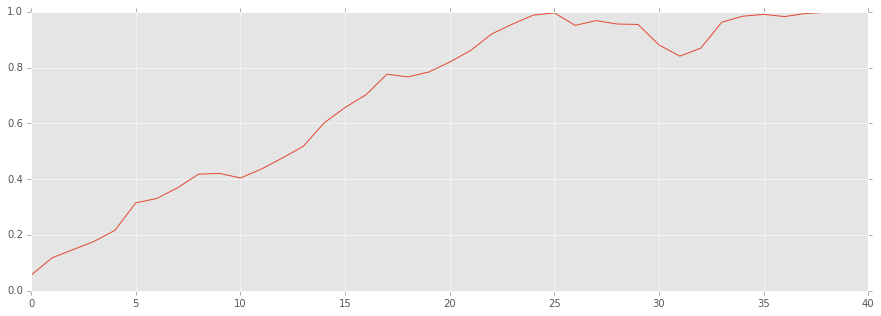

In [130]:
counts = np.array(X.sum(axis=1), dtype=int)
numer = pd.Series(counts[Z_output == 1]).value_counts()
denom = pd.Series(counts).value_counts()

numer.sort_index(inplace=True)
denom.sort_index(inplace=True)

print(numer)

propn = numer.values / denom.values

#plt.plot(numer,'g-')
#plt.plot(denom,'r-')
plt.plot(propn)

0     176451
1     121810
2      57665
3      36176
4      20527
5      10662
6       7937
7       6613
8       5511
9       5817
10      6753
11      6960
12      7446
13      7853
14      7325
15      7842
16      9591
17     10856
18     11787
19     12795
20     12410
21     10045
22      6756
23      4314
24      3226
25      2126
26      1293
27       879
28       659
29       651
30       547
31       657
32       481
33       126
34       173
35       135
36       116
37       146
38        49
dtype: int64


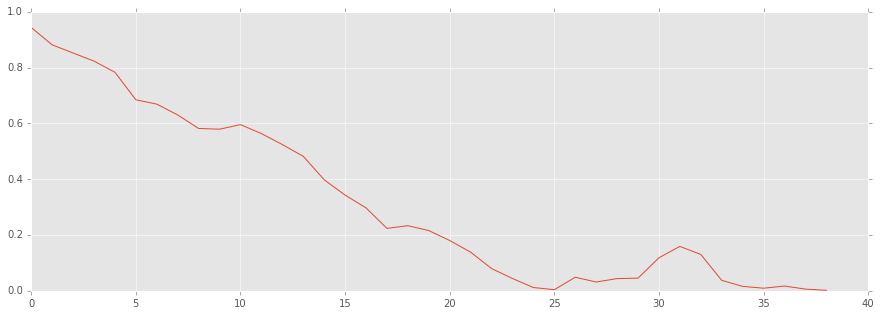

In [131]:
counts = np.array(X.sum(axis=1), dtype=int)
numer = pd.Series(counts[Z_output == 0]).value_counts()
denom = pd.Series(counts).value_counts()

numer.sort_index(inplace=True)
denom.sort_index(inplace=True)

print(numer)

propn = numer.values / denom.values

#plt.plot(numer,'g-')
#plt.plot(denom,'r-')
plt.plot(propn)